# Quantization in Neural Networks: Advantages and Limitations


Library that we will use:


*   TensorFlow + Keras
*   Larq



In [1]:
!pip install larq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import packages
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
import larq as lq
import matplotlib.pyplot as plt
%matplotlib inline


# Set seed
tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)   
tf.config.experimental.enable_op_determinism()

## Data preprocessing

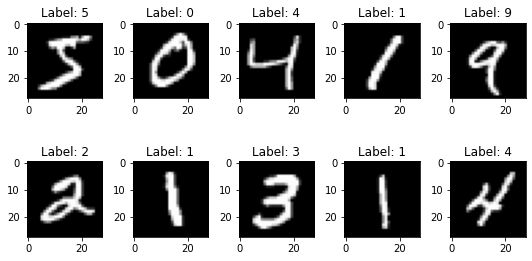

In [3]:
#Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#Plot images
num = 10
images = x_train[:num]
labels = y_train[:num]
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [4]:
print(x_train.shape)
# Flatten the image: from (60000,28,28) to (60000,28x28)
x_train = x_train.reshape(60000, 784,1)
x_test = x_test.reshape(10000, 784,1)
# interpret as float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# normalize between [0,1]
x_train /= 255
x_test /= 255

(60000, 28, 28)


## Model definition

In [26]:
# Define the type of the model: Sequential
model = tf.keras.models.Sequential()

# First layer: Fully-Connected, 512 Neurons, ReLU activation function
model.add(tf.keras.layers.Dense(512, input_shape=(784, ), activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
# Second layer: Fully-Connected, 64 Neurons, ReLU activation function
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
# Output layer: Fully-Connected, 10 Neurons, Softmax to perform classification 
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               401920    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 437,706
Trainable params: 436,554
Non-t

## Float32 Model Training

In [27]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

# Fitting the model with the dataset
hist = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test,y_test))

# Evaluate the model on the test set
score = model.evaluate(x_test, y_test, verbose=1)
float_accuracy = score[1]

print("Test loss {:.4f}, accuracy {:.2f}%".format(score[0], score[1] * 100))

#Save model weights to use them later
model.save('./float_model')

Epoch 1/20
469/469 [==============================] - 8s 15ms/step - loss: 0.1955 - accuracy: 0.9440 - val_loss: 0.1103 - val_accuracy: 0.9662
Epoch 2/20
469/469 [==============================] - 8s 16ms/step - loss: 0.0737 - accuracy: 0.9779 - val_loss: 0.0897 - val_accuracy: 0.9714
Epoch 3/20
469/469 [==============================] - 8s 16ms/step - loss: 0.0499 - accuracy: 0.9845 - val_loss: 0.0819 - val_accuracy: 0.9744
Epoch 4/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0352 - accuracy: 0.9893 - val_loss: 0.0724 - val_accuracy: 0.9774
Epoch 5/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0756 - val_accuracy: 0.9765
Epoch 6/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.0765 - val_accuracy: 0.9768
Epoch 7/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0746 - val_accuracy: 0.9794

## Direct Quantization

In [28]:
bitwidth = 1

# Larq definition of input and kernel quantizers
kwargs = dict(input_quantizer=lq.quantizers.DoReFa(k_bit=bitwidth, mode="activations"),
          kernel_quantizer=lq.quantizers.DoReFa(k_bit=bitwidth, mode="weights"),
          kernel_constraint="weight_clip"
          )

model = tf.keras.models.Sequential()

model.add(lq.layers.QuantDense(512, activation="relu", **kwargs,input_shape=(784, )))
model.add(tf.keras.layers.BatchNormalization())

model.add(lq.layers.QuantDense(64, activation="relu", **kwargs))
model.add(tf.keras.layers.BatchNormalization())

model.add(lq.layers.QuantDense(10, activation="softmax", **kwargs))

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

# Load trained model (float32) 
model.load_weights('./float_model')



# Evaluate the direct quantization
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss {:.4f}, accuracy {:.2f}%".format(score[0], score[1] * 100))
direct_quantization_accuracy = score[1]

313/313 [==============================] - 3s 6ms/step - loss: 2.8426 - accuracy: 0.5178
Test loss 2.8426, accuracy 51.78%


## Quantization-Aware Training

In [33]:
bitwidth = 1

# Larq definition of input and kernel quantizers
kwargs = dict(input_quantizer=lq.quantizers.DoReFa(k_bit=bitwidth, mode="activations"),
          kernel_quantizer=lq.quantizers.DoReFa(k_bit=bitwidth, mode="weights"),
          kernel_constraint="weight_clip"
          )

model = tf.keras.models.Sequential()

model.add(lq.layers.QuantDense(512, activation="relu", **kwargs,input_shape=(784, )))
model.add(tf.keras.layers.BatchNormalization())

model.add(lq.layers.QuantDense(64, activation="relu", **kwargs))
model.add(tf.keras.layers.BatchNormalization())

model.add(lq.layers.QuantDense(10, activation="softmax", **kwargs))

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

lq.models.summary(model)

# Quantization Aware Training
hist = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test,y_test))

# Evaluate the QAT
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss {:.4f}, accuracy {:.2f}%".format(score[0], score[1] * 100))
QAT_accuracy = score[1]



+sequential_19 stats-------------------------------------------------------------------+
| Layer                  Input prec.    Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                 x 1       x 1    (kB)             |
+--------------------------------------------------------------------------------------+
| quant_dense_36                   1  (-1, 512)   401408       512   51.00      401408 |
| batch_normalization_6            -  (-1, 512)        0      1024    4.00           0 |
| quant_dense_37                   1   (-1, 64)    32768        64    4.25       32768 |
| batch_normalization_7            -   (-1, 64)        0       128    0.50           0 |
| quant_dense_38                   1   (-1, 10)      640        10    0.12         640 |
+--------------------------------------------------------------------------------------+
| Total                                           434816      1738   59.87      434816 |
+--------------------

In [32]:
print("Accuracy results:")
print("Float32 {:.2f}%, Direct quantization {:.2f}%, QAT {:.2f}%".format(float_accuracy*100,direct_quantization_accuracy*100,QAT_accuracy*100))

Accuracy results:
Float32 97.76%, Direct quantization 51.78%, QAT 95.22%
